In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

# 设置随机种子以便复现结果
torch.manual_seed(50)

# 定义DenseNet基本块
class BottleneckLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([x, out], 1)
        return out

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out
    
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckLayer(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)
    
class DenseNet(nn.Module):
    def __init__(self, num_classes=10, growth_rate=12, block_config=(16, 16, 16)):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=3, padding=1, bias=False)
        self.dense1 = DenseBlock(block_config[0], 2 * growth_rate, growth_rate)
        self.trans1 = TransitionLayer(2 * growth_rate + block_config[0] * growth_rate, growth_rate)
        self.dense2 = DenseBlock(block_config[1], growth_rate, growth_rate)
        self.trans2 = TransitionLayer(growth_rate + block_config[1] * growth_rate, growth_rate)
        self.dense3 = DenseBlock(block_config[2], growth_rate, growth_rate)
        self.bn = nn.BatchNorm2d(growth_rate + block_config[2] * growth_rate)
        self.linear = nn.Linear(growth_rate + block_config[2] * growth_rate, num_classes)

    def forward(self, out):
        out = self.conv1(out)
        out = self.dense1(out)
        out = self.trans1(out)
        out = self.dense2(out)
        out = self.trans2(out)
        out = self.dense3(out)
        out = torch.squeeze(F.avg_pool2d(F.relu(self.bn(out)), 8))
        out = F.log_softmax(self.linear(out), dim=1)
        return out

In [6]:

net = DenseNet(num_classes=10, growth_rate=32, block_config=(8, 8, 8))
print(net)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = net.to(device)

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): DenseBlock(
    (block): Sequential(
      (0): BottleneckLayer(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BottleneckLayer(
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (2): BottleneckLayer(
        (bn1): Batc

In [7]:
def train_and_evaluate(model, trainloader, testloader, num_epochs=10, learning_rate=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')
        scheduler.step()
     # 绘制损失和准确度曲线
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # 绘制训练损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制训练和测试准确度曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'r', label='Test accuracy')
    plt.title('Training and Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 1.4256, Train Accuracy: 47.13%, Test Accuracy: 55.80%
Epoch [2/10], Loss: 0.9544, Train Accuracy: 65.72%, Test Accuracy: 68.49%
Epoch [3/10], Loss: 0.7586, Train Accuracy: 73.37%, Test Accuracy: 69.10%
Epoch [4/10], Loss: 0.6384, Train Accuracy: 77.82%, Test Accuracy: 76.81%
Epoch [5/10], Loss: 0.5518, Train Accuracy: 81.02%, Test Accuracy: 78.01%
Epoch [6/10], Loss: 0.4911, Train Accuracy: 83.05%, Test Accuracy: 79.59%
Epoch [7/10], Loss: 0.4472, Train Accuracy: 84.75%, Test Accuracy: 79.08%
Epoch [8/10], Loss: 0.4091, Train Accuracy: 86.00%, Test Accuracy: 82.17%
Epoch [9/10], Loss: 0.3787, Train Accuracy: 86.90%, Test Accuracy: 83.65%
Epoch [10/10], Loss: 0.3559, Train Accuracy: 87.78%, Test Accuracy: 83.82%


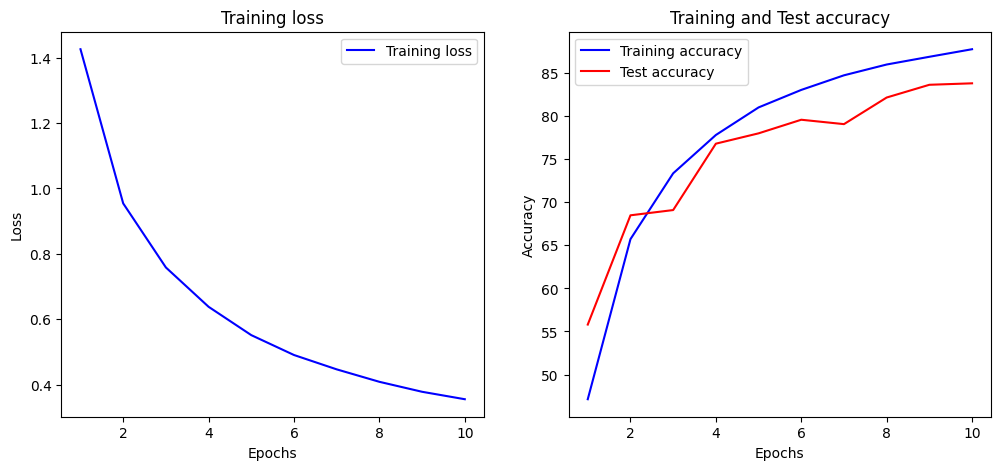

In [8]:
transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

train_and_evaluate(model, trainloader, testloader, num_epochs=10, learning_rate=0.01)